In [62]:
import numpy as np
import pandas as pd
import scipy as sp


%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 12}

plt.rc('font', **font)

import fair
from fair.fair_inverse_model import co2_conc_total as rf_to_conc
from fair.fair_inverse_model import annual_emissions_calc2 as conc_to_emissions
from fair.forward import fair_scm as FAIR_model
fair.__version__

'1.0.1'

In [84]:
# Using Fair to go RCP3PD emissions -> radiative forcings for CH4 and CO2

emms_file = './fair/RCPs/RCP3PD_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']

concs_filem = './fair/GCP_data/RCP3PD_MIDYEAR_CONCENTRATIONS.csv'
concs_datam = np.genfromtxt(concs_filem,skip_header=37,delimiter=',',names=True)
M_concs = concs_datam['CH4']
N_concs = concs_datam['N2O']
concs = concs_datam['CO2']

forc_file = './fair/RCPs/RCP3PD_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_INCLVOLCANIC_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF']

C,T,RF,M,N,MK_gas,db,tau_M,tau_N = FAIR_model(emissions=emissions,M_emissions=M_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.0316, tau_M_0 = 9.0)

C_1,T_1,RF_1,M_1,N_1,MK_gas_1,db_1,tau_M_1,tau_N_1 = FAIR_model(emissions=emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.0316, tau_M_0 = 9.0)

C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:21: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:25: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



In [85]:
# Convert forcings to concentrations

#taking sums of radiative forcings

co2_plus_ch4_rf = RF-RF_1 + db['CO2']['forcing']

other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF']
anthro_rf = forc_data['TOTAL_ANTHRO_RF']

anthro_CO2_eq_concs = rf_to_conc(anthro_rf)
CO2_CO2_eq_concs = rf_to_conc(db['CO2']['forcing'])
CO2_plus_CH4_CO2_eq_concs = rf_to_conc(co2_plus_ch4_rf)
CO2_plus_other_CO2_eq_concs = rf_to_conc(db['CO2']['forcing'] + other_rf) # total anthro - CO2,Ch4

In [86]:
# Convert concentrations to emissions CO2

CO2_CO2_eq_emms = conc_to_emissions(CO2_CO2_eq_concs,T,year_smoothing=5) * 44./12.
CO2_plus_CH4_CO2_eq_emms = conc_to_emissions(CO2_plus_CH4_CO2_eq_concs,T,year_smoothing=5) * 44./12.
CO2_plus_other_CO2_eq_emms = conc_to_emissions(CO2_plus_other_CO2_eq_concs,T,year_smoothing=5) * 44./12.

anthro_CO2_eq_emms = conc_to_emissions(anthro_CO2_eq_concs,T,year_smoothing=5) * 44./12.

CH4_CO2_eq_emms = CO2_plus_CH4_CO2_eq_emms - CO2_CO2_eq_emms
other_CO2_eq_emms = CO2_plus_other_CO2_eq_emms - CO2_CO2_eq_emms
total_CO2_eq_emms = np.sum([CO2_CO2_eq_emms,CH4_CO2_eq_emms,other_CO2_eq_emms],axis=0)

(-600.0, 3500)

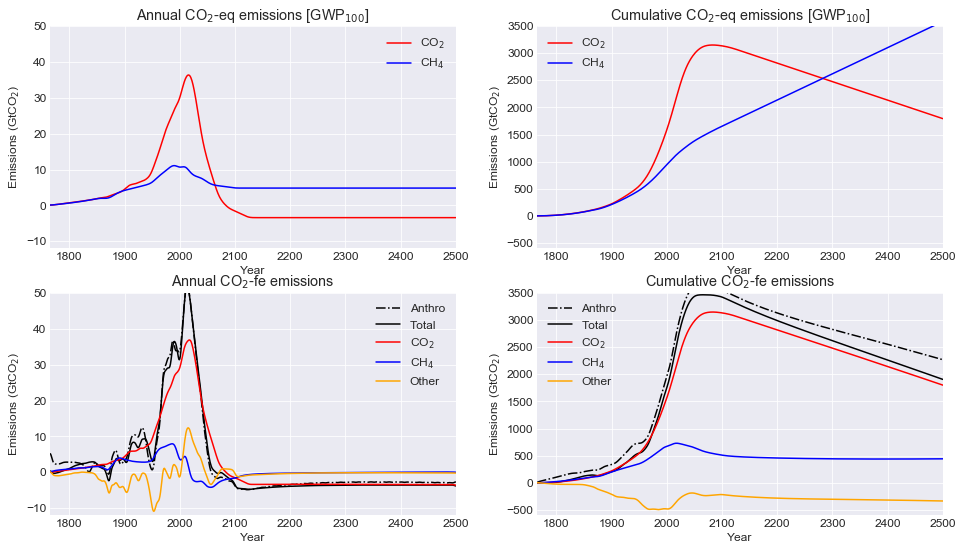

In [87]:
from scipy.ndimage.filters import gaussian_filter as smooth

time = np.arange(1765,2501)
CO2_emissions = emissions * 44./12.
CH4_CO2_eq_GWP = M_emissions * 34./1000.

cum_CO2_fe = np.cumsum(CO2_CO2_eq_emms)
cum_CH4_fe = np.cumsum(CH4_CO2_eq_emms)
cum_anthro_fe = np.cumsum(anthro_CO2_eq_emms)
cum_total_fe = np.cumsum(total_CO2_eq_emms)
cum_other_fe = np.cumsum(other_CO2_eq_emms)

# Smoothing

CO2_emissions_smooth = smooth(CO2_emissions,5)
CH4_CO2_eq_GWP_smooth = smooth(CH4_CO2_eq_GWP,5)
cum_CO2_emms_GWP = np.cumsum(CO2_emissions_smooth)
cum_CH4_emms_GWP = np.cumsum(CH4_CO2_eq_GWP_smooth)

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(time,CO2_emissions_smooth,label='CO$_2$',color='red')
ax1.plot(time,CH4_CO2_eq_GWP_smooth,label='CH$_4$',color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Emissions (GtCO$_2$)')
ax1.set_title('Annual CO$_2$-eq emissions [GWP$_{100}$]')
ax1.legend(loc='best')
ax1.set_xlim(1765,2500)
ax1.set_ylim(-12.,50)

ax2.plot(time,cum_CO2_emms_GWP,label='CO$_2$',color='red')
ax2.plot(time,cum_CH4_emms_GWP,label='CH$_4$',color='blue')
ax2.set_xlabel('Year')
ax2.set_ylabel('Emissions (GtCO$_2$)')
ax2.set_title('Cumulative CO$_2$-eq emissions [GWP$_{100}$]')
ax2.legend(loc='best')
ax2.set_xlim(1765,2500)
ax2.set_ylim(-600.,3500)

ax3.plot(time,anthro_CO2_eq_emms,'-.',label='Anthro',color='black')
ax3.plot(time,total_CO2_eq_emms,label='Total',color='black')
ax3.plot(time,CO2_CO2_eq_emms,label='CO$_2$',color='red')
ax3.plot(time,CH4_CO2_eq_emms,label='CH$_4$',color='blue')
ax3.plot(time,other_CO2_eq_emms,label='Other',color='orange')
ax3.set_xlabel('Year')
ax3.set_ylabel('Emissions (GtCO$_2$)')
ax3.set_title('Annual CO$_2$-fe emissions')
ax3.legend(loc='best')
ax3.set_xlim(1765,2500)
ax3.set_ylim(-12.,50)

ax4.plot(time,cum_anthro_fe,'-.',label='Anthro',color='black')
ax4.plot(time,cum_total_fe,label='Total',color='black')
ax4.plot(time,cum_CO2_fe,label='CO$_2$',color='red')
ax4.plot(time,cum_CH4_fe,label='CH$_4$',color='blue')
ax4.plot(time,cum_other_fe,label='Other',color='orange')
ax4.set_xlabel('Year')
ax4.set_ylabel('Emissions (GtCO$_2$)')
ax4.set_title('Cumulative CO$_2$-fe emissions')
ax4.legend(loc='best')
ax4.set_xlim(1765,2500)
ax4.set_ylim(-600.,3500)

#ANTHRO - from RCP3 RF data, total anthropogenic emissions calculated by fair inverse model.
#TOTAL - using fair forward co2 and ch4 data, and rcp everything else
#CO2 - co2 emissions calculated forwards from emissions to RF data, and backwards in fair inverse model
#CH4 - ch4 plus co2 emissions calculated from sums of RF calculated using fair forwards and emissions data, then differencing with 
        #just co2 to get methane contribution to emissions (co2-fe)
#OTHER - anthro rf data set from RCP3 minus co2 and ch4 from RCP3 data plus our calculated co2 rf. We then find emissions for this 
        #and remove the contribution from the co2 emissions calculated, and hence find contribution jsut due to other emissions